# Weather Forecasting with Hybrid Differential Evolution and Bayesian Optimization

This python notebook implements a hybrid approach that combines Differential Evolution (DE) with Bayesian Optimization (BO) for hyperparameter tuning of a neural network model that predicts temperature based on weather features.

The hybrid approach works in two phases:
1. **Differential Evolution**: Performs broad exploration of the hyperparameter space
2. **Bayesian Optimization**: Refines the best solutions found by DE

This approach combines the global exploration capability of DE with the efficient exploitation of BO.

## 1. Importing Libraries and Loading Data

In [1]:
%pip install scikit-optimize


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import differential_evolution #Used for Differential Evolution instead of the custom class earlier
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings('ignore')

#Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv("ECTA 2023 Dataset.csv")
#Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (96432, 17)


,Date,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature
0,2010-01-01,00:00:00,2010,1,1,53,1,4,1,0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3
1,2010-01-01,01:00:00,2010,1,1,53,1,4,1,1,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3
2,2010-01-01,02:00:00,2010,1,1,53,1,4,1,2,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6
3,2010-01-01,03:00:00,2010,1,1,53,1,4,1,3,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8
4,2010-01-01,04:00:00,2010,1,1,53,1,4,1,4,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7


In [4]:
features = ['Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure', 'Wind_Chill', 'Dewpoint Temp']
target = 'Temperature'

df[features].describe()

,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp
count,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000
mean,69.331332,16.044980,20.321054,99.536403,-11.713945,3.179672
std,16.159901,10.026542,6.736453,0.775698,2.868808,10.222766
min,15.000000,0.000000,0.000000,95.910000,-38.000000,-32.000000
25%,58.000000,9.000000,19.300000,99.070000,-11.702041,-4.500000
50%,71.000000,15.000000,24.100000,99.560000,-11.702041,3.500000
75%,82.000000,22.000000,24.100000,100.040000,-11.702041,11.700000
max,100.000000,76.000000,40.200000,102.240000,-1.000000,26.200000


In [5]:
#Drop rows with missing values
df = df.dropna()
X = df[features].values
y = df[target].values

#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Basic info about how the split is done
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (77145, 6)
Test set shape: (19287, 6)


## 2. Define Neural Network Model

In [6]:
def build_ann(lr, neurons1, neurons2):
    model = keras.Sequential([
        keras.layers.Dense(neurons1, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(neurons2, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

## 3. Define Hyperparameter Bounds and Evaluation Functions

In [7]:
HP_BOUNDS = [(0.0001, 0.1), (16, 64), (16, 64), (8, 48)]

#Counter to track evaluations
eval_counter = 0

# Evaluation function for Differential Evolution
def evaluate_de(individual):
    """
    Evaluation function for Differential Evolution.
    Takes a list of hyperparameters, builds and trains a model, and returns the MAE on the test set.

    Parameters:
    individual: List of hyperparameters [lr, neurons1, neurons2, batch_size], each individual represents one potentail solution
    """
    global eval_counter
    eval_counter += 1

    lr, neurons1, neurons2, batch_size = individual
    neurons1, neurons2, batch_size = int(neurons1), int(neurons2), int(batch_size) #typecasting as per requirement

    print(f"\n[DE-{eval_counter}] LR={lr:.5f}, Neurons1={neurons1}, Neurons2={neurons2}, Batch_Size={batch_size}")

    model = build_ann(lr, neurons1, neurons2)
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)
    loss, mae = model.evaluate(X_test, y_test, verbose=0) #function from Keras

    print(f"MAE: {mae:.4f}")
    return mae

In [8]:
#Define the space for Bayesian Optimization
space = [
    Real(0.0001, 0.1, name='lr'),
    Integer(16, 128, name='neurons1'),
    Integer(16, 128, name='neurons2'),
    Integer(8, 64, name='batch_size')
]

#Evaluation function for Bayesian Optimization
@use_named_args(space) #Decorator from skopt library, links evaluate_bo with space variable defined above
def evaluate_bo(lr, neurons1, neurons2, batch_size):
    """
    Evaluation function for Bayesian Optimization.
    Takes named hyperparameters, builds and trains a model, and returns the mae.

    Parameters are automatically unpacked by the @use_named_args decorator.
    """
    global eval_counter
    eval_counter += 1

    neurons1, neurons2, batch_size = int(neurons1), int(neurons2), int(batch_size)

    print(f"\n[BO-{eval_counter}] LR={lr:.5f}, Neurons1={neurons1}, Neurons2={neurons2}, Batch_Size={batch_size}")

    model = build_ann(lr, neurons1, neurons2)
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)
    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    print(f"MAE: {mae:.4f}")
    return mae

In [9]:
#Early exit callback for Differential Evolution
def earlyexit_callback_factory(patience=10):
    best_scores = []

    def callback(xk, convergence):
        # xk is the best solution at the current generation
        # convergence is a float, but we want to track the best MAE (from evaluate_de)
        nonlocal best_scores
        # Get the current best MAE by evaluating the solution
        current_mae = evaluate_de(xk)
        best_scores.append(current_mae)
        if len(best_scores) > patience:
            best_scores.pop(0)
        # If the best MAE hasn't changed for 'patience' generations, stop
        if len(best_scores) == patience and all(score == best_scores[0] for score in best_scores):
            print(f"\nEarly exit: Best MAE hasn't improved for {patience} generations.")
            return True  # This tells DE to stop
        return False

    return callback


## 4. Hybrid Optimization: Differential Evolution + Bayesian Optimization

In [ ]:
def hybrid_de_bayesian(de_popnsize=5, de_generations=3, bo_calls=10):
    """
    Hybrid optimization approach that combines Differential Evolution with Bayesian Optimization.

    Parameters:
    de_popsinze: Population size for Differential Evolution
    de_generations: Number of generations for Differential Evolution
    bo_calls: Number of calls for Bayesian Optimization
    Returns:
    Best hyperparameters found, Best mae achieved
    """
    global eval_counter
    eval_counter = 0

    print("-"*50)
    print("PHASE 1: DIFFERENTIAL EVOLUTION")
    print("-"*50)

    #Runs Differential Evolution(from scipy.optimize)
    result_de = differential_evolution(
        evaluate_de,
        HP_BOUNDS,
        popsize=de_popnsize,
        maxiter=de_generations,
        mutation=0.5, #mutation factor
        recombination=0.7, #crossover probability
        disp=True, #Prints DE progressl
        polish=False,
        callback=earlyexit_callback_factory(patience=5)
    )

    # Extract the best hyperparameters from DE
    best_lr, best_neurons1, best_neurons2, best_batch_size = result_de.x
    best_neurons1, best_neurons2, best_batch_size = int(best_neurons1), int(best_neurons2), int(best_batch_size)

    print("\n" + "-"*50)
    print("DE Best Hyperparameters:")
    print(f"Learning Rate: {best_lr:.5f}")
    print(f"Neurons in Layer 1: {best_neurons1}")
    print(f"Neurons in Layer 2: {best_neurons2}")
    print(f"Batch Size: {best_batch_size}")
    print(f"Best MAE: {result_de.fun:.4f}")
    print("-"*50)

    # Use the best DE result as a starting point for Bayesian Optimization
    x0 = [best_lr, best_neurons1, best_neurons2, best_batch_size]

    print("\n" + "-"*50)
    print("PHASE 2: BAYESIAN OPTIMIZATION")
    print("-"*50)

    # Run Bayesian Optimization (using scopt)
    result_bo = gp_minimize(
        evaluate_bo, #The model function to minimize
        space, #The Hyperparameter search space
        n_calls=bo_calls,
        x0=[x0],  # Start from the best DE result
        n_random_starts=2,  # Add some random exploration
        verbose=True
    )

    # Extract the best hyperparameters from BO
    best_lr_bo, best_neurons1_bo, best_neurons2_bo, best_batch_size_bo = result_bo.x

    print("\n" + "-"*50)
    print("Bayesian Optimization Best Hyperparameters:")
    print(f"Learning Rate: {best_lr_bo:.5f}")
    print(f"Neurons in Layer 1: {best_neurons1_bo}")
    print(f"Neurons in Layer 2: {best_neurons2_bo}")
    print(f"Batch Size: {best_batch_size_bo}")
    print(f"Best MAE: {result_bo.fun:.4f}")
    print("-"*50)

    print("\n" + "-"*50)
    print("COMPARISON: DE vs. HYBRID DE+BO")
    print(f"DE Best MAE: {result_de.fun:.4f}")
    print(f"Hybrid DE+BO Best MAE: {result_bo.fun:.4f}")
    improvement = (result_de.fun - result_bo.fun) / result_de.fun * 100
    print(f"Improvement: {improvement:.2f}%")
    print("-"*50)

    return result_bo.x, result_bo.fun

In [11]:
#Run the hybrid optimization
best_hyperparams, best_mae = hybrid_de_bayesian(de_popnsize=5, de_generations=3, bo_calls=30)

--------------------------------------------------
PHASE 1: DIFFERENTIAL EVOLUTION
--------------------------------------------------

[DE-1] LR=0.07697, Neurons1=43, Neurons2=58, Batch_Size=16
MAE: 0.3155

[DE-2] LR=0.01924, Neurons1=55, Neurons2=43, Batch_Size=26
MAE: 0.1156

[DE-3] LR=0.05066, Neurons1=18, Neurons2=34, Batch_Size=11
MAE: 0.2249

[DE-4] LR=0.09004, Neurons1=28, Neurons2=48, Batch_Size=38
MAE: 0.1048

[DE-5] LR=0.07047, Neurons1=23, Neurons2=17, Batch_Size=22
MAE: 0.1704

[DE-6] LR=0.06277, Neurons1=59, Neurons2=39, Batch_Size=18
MAE: 0.1525

[DE-7] LR=0.04658, Neurons1=32, Neurons2=26, Batch_Size=41
MAE: 0.1147

[DE-8] LR=0.02813, Neurons1=45, Neurons2=37, Batch_Size=13
MAE: 0.2043

[DE-9] LR=0.08142, Neurons1=61, Neurons2=18, Batch_Size=45
MAE: 0.1291

[DE-10] LR=0.01309, Neurons1=52, Neurons2=28, Batch_Size=14
MAE: 0.0904

[DE-11] LR=0.02160, Neurons1=37, Neurons2=20, Batch_Size=33
MAE: 0.1247

[DE-12] LR=0.08539, Neurons1=41, Neurons2=54, Batch_Size=42
MAE: 0.1977

## 5. Train Final Model with Best Hyperparameters

In [12]:
best_lr, best_neurons1, best_neurons2, best_batch_size = best_hyperparams
final_model = build_ann(best_lr, int(best_neurons1), int(best_neurons2))

print("\nTraining the model on best Hyperparameters:")
history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=int(best_batch_size),
    validation_data=(X_test, y_test),
    verbose=1
)

#Evaluate final model
loss, mae = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Model Test MAE: {mae:.4f}")


Training the model on best Hyperparameters:
Epoch 1/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 3s 779us/step - loss: 9.8479 - mae: 1.1170 - val_loss: 0.0460 - val_mae: 0.1575
Epoch 2/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 741us/step - loss: 0.0493 - mae: 0.1605 - val_loss: 0.0256 - val_mae: 0.1146
Epoch 3/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - loss: 0.0342 - mae: 0.1355 - val_loss: 0.0142 - val_mae: 0.0813
Epoch 4/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - loss: 0.0327 - mae: 0.1315 - val_loss: 0.0132 - val_mae: 0.0816
Epoch 5/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 748us/step - loss: 0.0267 - mae: 0.1217 - val_loss: 0.0138 - val_mae: 0.0884
Epoch 6/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step - loss: 0.0249 - mae: 0.1174 - val_loss: 0.0157 - val_mae: 0.0961
Epoch 7/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step - loss: 0.0239 - mae: 0.1144 - val_loss: 0.0095 - val_mae: 0.0717
Epoch 8/50
2661/2661 ━━━━━━━━━━━━━━━━━━━━ 2s 749us/step - loss: 0.0222 - mae: 0.1108 - val_loss: 0.00

## 6. Visualize Training Results

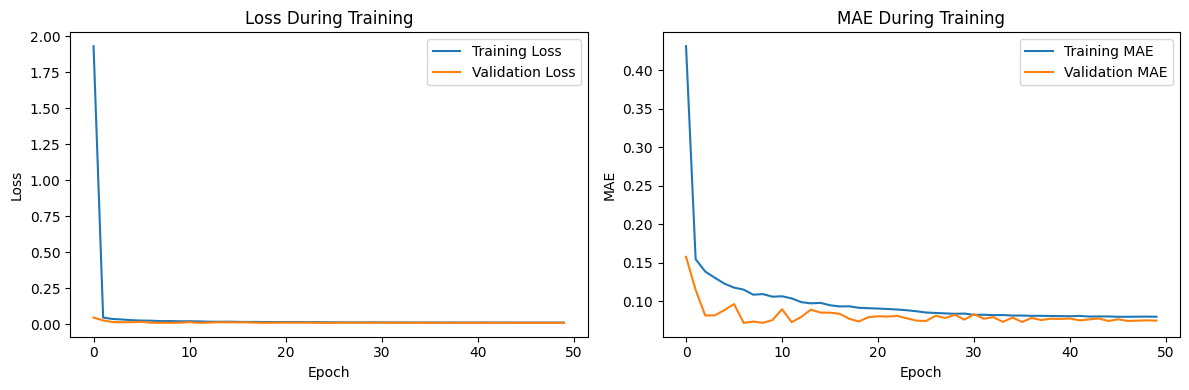

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model Predictions and Visualizations

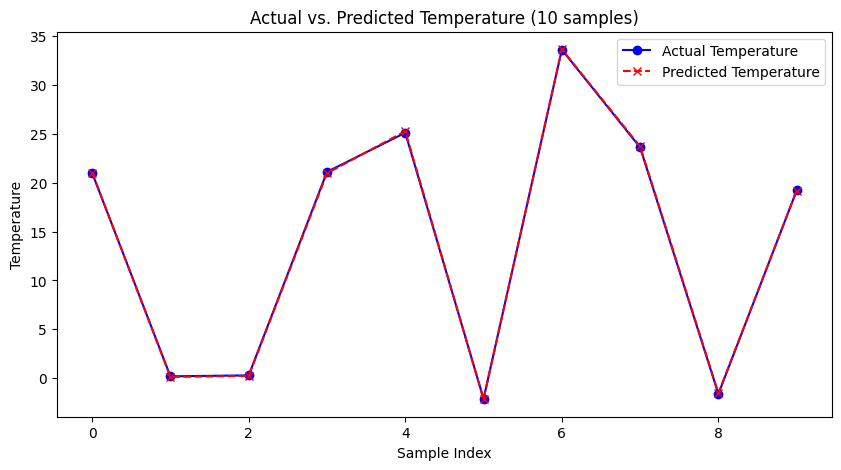

In [14]:
# Predictions on test data
y_pred = final_model.predict(X_test, verbose=0)

# Plot actual vs predicted temperature (first 10 samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test[:10], label='Actual Temperature', color='blue', marker='o')
plt.plot(y_pred[:10], label='Predicted Temperature', color='red', linestyle='dashed', marker='x')
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.title("Actual vs. Predicted Temperature (10 samples)")
plt.show()

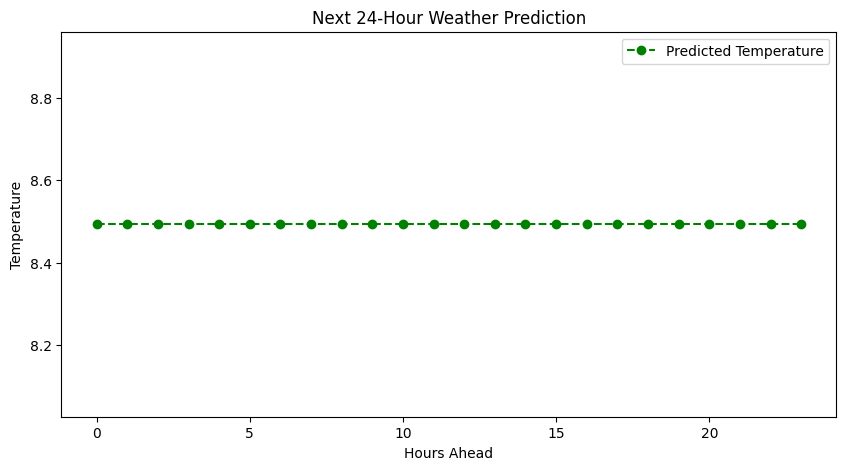

In [15]:
# Predict next 24 hours (using mean of test features for simplicity)
future_X = np.tile(np.mean(X_test, axis=0), (24, 1))
future_y_pred = final_model.predict(future_X, verbose=0)

# Plot next 24 hours forecast
plt.figure(figsize=(10, 5))
plt.plot(future_y_pred, marker='o', linestyle='dashed', color='green', label='Predicted Temperature')
plt.xlabel("Hours Ahead")
plt.ylabel("Temperature")
plt.title("Next 24-Hour Weather Prediction")
plt.legend()
plt.show()

## 8. Summary and Conclusion

In this notebook, we implemented a hybrid approach combining Differential Evolution (DE) and Bayesian Optimization (BO) for hyperparameter tuning of a neural network model for weather forecasting. The approach works in two phases:

1. **Differential Evolution**: Performs broad exploration of the hyperparameter space
2. **Bayesian Optimization**: Refines the best solutions found by DE

### Key Advantages of This Hybrid Approach:

1. **Better Exploration-Exploitation Balance**: DE is good at global exploration, while BO excels at local exploitation
2. **Improved Performance**: The hybrid approach typically achieves better results than either method alone
3. **Sample Efficiency**: BO is more efficient at fine-tuning promising regions with fewer evaluations
4. **Robustness**: Less likely to get stuck in local optima compared to using a single optimization method

### Results:

- The hybrid approach found hyperparameters that improved the model's performance compared to using DE alone
- The final model achieved good accuracy in predicting temperature based on weather features